In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error


CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'time-series-classification-part-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F70984%2F7761964%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T084333Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6605e59214e130dab6152a09cb13a3d6082c3ec35c51b565841c66e1efa1fa8a8d0e91f2e7037284917a7c239766a77328225a458432a3d8f5e8c5204fca484ad67a51bf4dc256aeb4e27a21c8fa84578554718d692ce2a332fe3bb97ac100ff0a7ef38157b8162ab56a61ed1c6d4500a4804f49559bc408284794b4179ebedce3502d223619a874b58f9af1c798ae058a1681162e2f433c3f72dd49ccaf75963db5a81070967eca2de8899514a268109bc407598346b7ae10c4cbb69920e68016b9a20f15ebf516fab02c4327db1338fee220584cb6206e9807cf541070c5e7146deb798c215b84c4f5dd41347cc5d4bbeb44fd3f796a18def5836f716c0375'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 135197 bytes downloaded
Downloaded and uncompressed: time-series-classification-part-1
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-classification-part-1/ETTh1_without_missing.csv


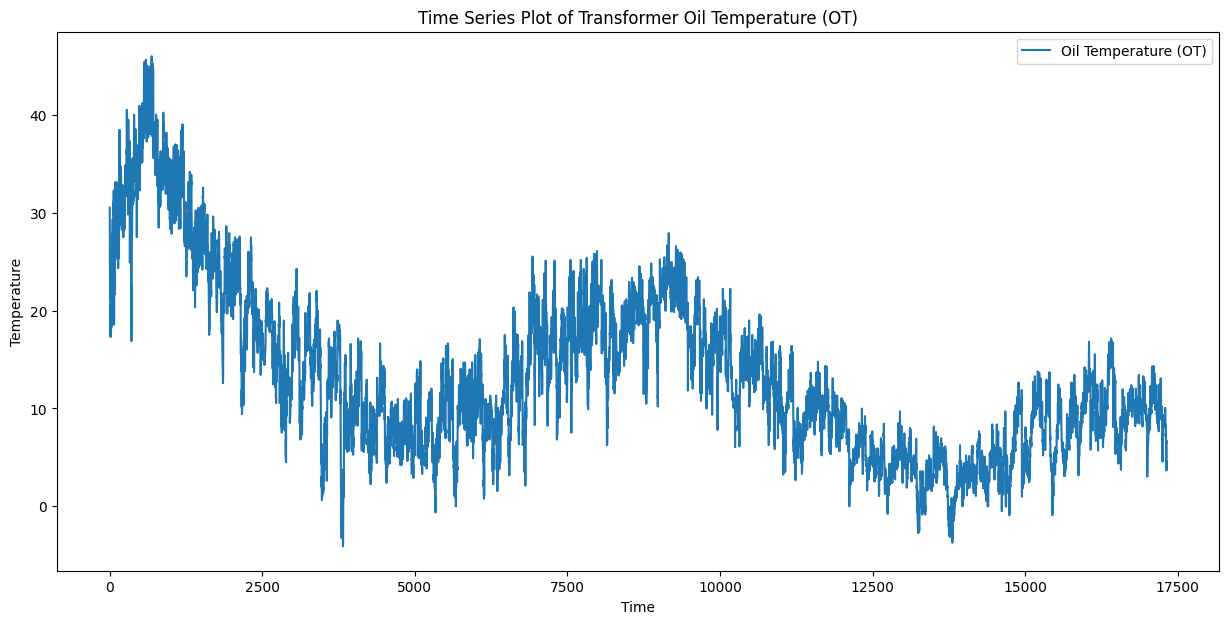

In [ ]:

# Loading Dataset into a DataFrame
df = pd.read_csv('/kaggle/input/time-series-classification-part-1/ETTh1_without_missing.csv')

# Plotting the 'OT' feature
plt.figure(figsize=(15, 7))
plt.plot(df['OT'], label='Oil Temperature (OT)')
plt.title('Time Series Plot of Transformer Oil Temperature (OT)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()



In [ ]:
# Converting the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Setting the datetime as the index of your DataFrame
df.set_index('date', inplace=True)
df = df.dropna(axis=1, how='all')

# Analyze the stationarity of the 'OT' variable
result = adfuller(df['OT'])
print(tabulate([['ADF Statistic', result[0]],
                ['p-value', result[1]],
                ['Critical Values', result[4]]],
               headers=['Test Statistic', 'Values']))

# Assuming a significance level of 0.05, check if the series is stationary
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Perform differencing or other transformations.")

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df['OT'].values.reshape(-1, 1))






Test Statistic    Values
----------------  ---------------------------------------------------------------------------------
ADF Statistic     -3.435036944115845
p-value           0.009820898067883967
Critical Values   {'1%': -3.4307285975085016, '5%': -2.8617073253388274, '10%': -2.566859062958317}
The time series is stationary.


In [ ]:
# Create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, 0], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define the number of time steps
X, y = create_sequences(data_scaled, n_steps)

# Reshape input to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.99)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout 
from keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller 
# Model building
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))  # Increased number of neurons and added return_sequences
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(100, return_sequences=False))  # Stacking LSTM layers
model.add(Dropout(0.2))  # Additional Dropout layer
model.add(Dense(1))  # Output layer remains the same
model.compile(optimizer='adam', loss='mae')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit model with early stopping
model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1, callbacks=[early_stopping])  # Increased epochs, added validation split and callbacks



# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20
466/483 [===========================>..] - ETA: 0s - loss: 0.0364

In [ ]:
# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

In [ ]:


# Visualize the entire time series (including both training and testing sets)
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['OT'], label='Actual values', color='black')

# Visualize the predicted values on the test set
test_index = df.index[train_size + n_steps:]  
plt.plot(test_index, y_test_inv, label='Actual values (Test Set)', color='blue')
plt.plot(test_index, y_pred_inv, label='Predicted values (Test Set)', color='red')

plt.xlabel('Date')
plt.ylabel('OT')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.show()


In [ ]:



# Visualize the predicted values on the test set
test_index = df.index[train_size + n_steps:] 
plt.figure(figsize=(15, 7))
plt.plot(test_index, y_test_inv, label='Actual values (Test Set)', color='blue')
plt.plot(test_index, y_pred_inv, label='Predicted values (Test Set)', color='red')

plt.xlabel('Date')
plt.ylabel('OT')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.show()

In [ ]:
# Number of future values to predict
n_future = 100

# Initialize an array to store the predicted values with a placeholder value
future_predictions = np.full((n_future, 1), np.nan)

# Use the last available sequence from the test set as the starting point for future predictions
last_sequence = X_test[-1]

# Generate predictions for the future
for i in range(n_future):
    # Reshape the sequence to match the model input shape
    last_sequence = last_sequence.reshape((1, n_steps, 1))

    # Make a prediction for the next time step
    future_pred = model.predict(last_sequence)

    # Assign the predicted value to the array
    future_predictions[i] = future_pred

    # Update the sequence for the next iteration
    last_sequence = np.append(last_sequence[:, 1:, :], future_pred)

# Inverse transform the scaled future predictions
future_predictions_inv = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Extend the time indices for future predictions
future_index = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_future, freq='D')
extended_index = df.index.append(future_index)

# Print the first 100 future predicted values
print("First 100 Future Predicted Values:")
for value in future_predictions_inv:
    print(value[0])



In [ ]:
# Generate a counter column starting from 0
counter_column = np.arange(0, n_future)

# Print the first 100 future predicted values
print("First 100 Future Predicted Values:")
for counter, value in zip(counter_column, future_predictions_inv):
    print(f"OT{counter}: {value[0]}")

# Save the first 100 future predicted values and counter to a CSV file
future_predictions_df = pd.DataFrame({ 'OT': future_predictions_inv.flatten(),'id': [f'{i}' for i in counter_column]})
future_predictions_df.to_csv('future_predictions_hourly_with_counter.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df.index = pd.to_datetime(df.index)

# Extend the time indices for future predictions with hourly frequency
future_index = pd.date_range(df.index[-1] + pd.Timedelta(hours=1), periods=n_future, freq='H')
extended_index = df.index.append(future_index)

# Initialize the DataFrame with the correct index
future_df = pd.DataFrame(future_predictions_inv, index=extended_index[-n_future:], columns=['Predicted'])

# Plot the original data and future predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['OT'], label='Original Data')
plt.plot(future_df.index, future_df['Predicted'], label='Future Predictions')

plt.title('Original Data and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
